In [21]:
# imports and loadings
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
genes = ['b1101', 'b1817', 'b1818', 'b1819']


t_half_life_deg = 300
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : True,
    'sanity_plots' : True,
    'central_gene' : 'b1819',
    'act_iM' : 'Crp-1',
    'inh_iM' : 'DhaR/Mlc',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.2, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.2, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.2, # add this %age of the maximum to the top
    'cActivator' : [-4,2], # Uses a log10 range
    'cInhibitor': [-4,2], # Uses a log10 range
    'run_greedy' : True, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'scale_input' : True, # not sure if this works... let me think... normalize the range of cActivator and cInhibitor to [0, 1] for all, rescale results afterwards
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    'cell_constants' : { # should hold true across all samples, I think...
        'RNAP': 10**-6,
        'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
        'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
        'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
        'promoterConcVal': 10**-9, # Promoter concentration
    }
}



def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [60]:
# multiprocess run

# setup inputs
gene_flags = []

for gene in genes:
    temp_flags = flags.copy()
    temp_flags['central_gene'] = gene
    gene_flags.append(temp_flags)

# run pool
pool = multiprocessing.Pool(processes = len(genes))
results = pool.map(cdg.create_data_for_gene, gene_flags)
pool.close()
pool.join()

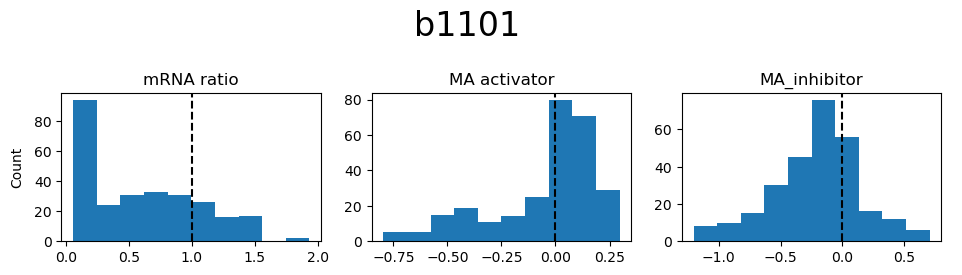

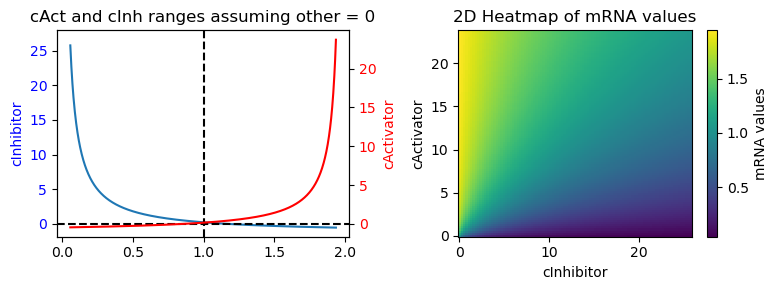

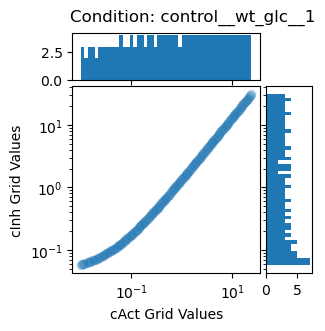

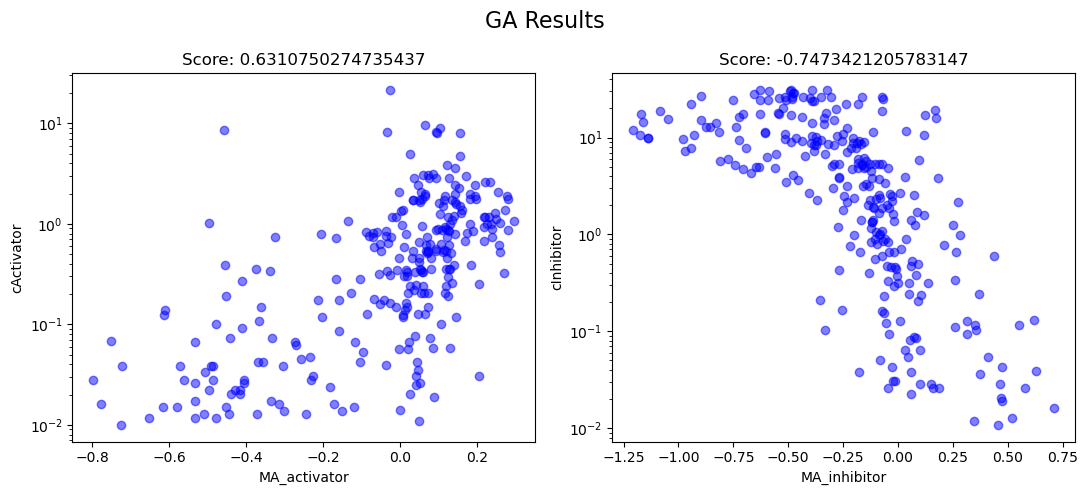

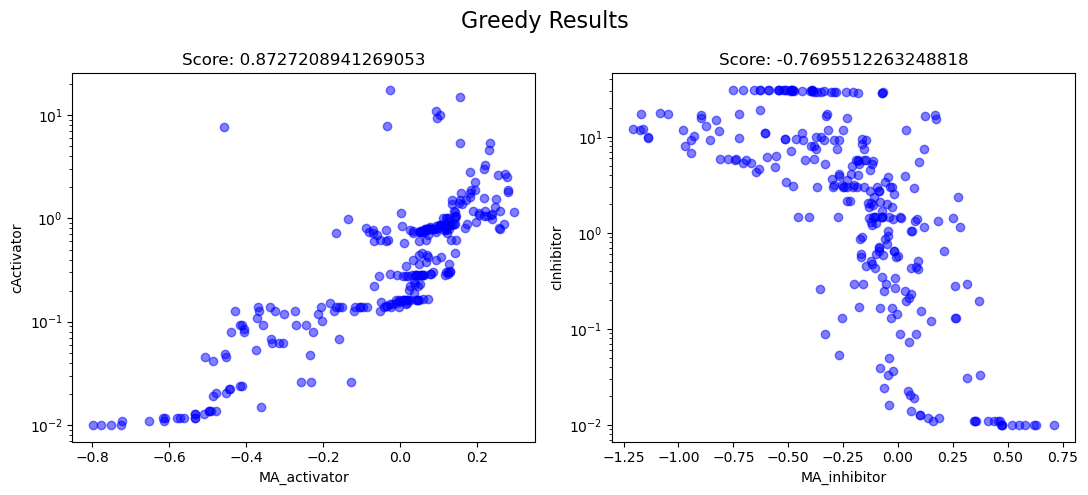

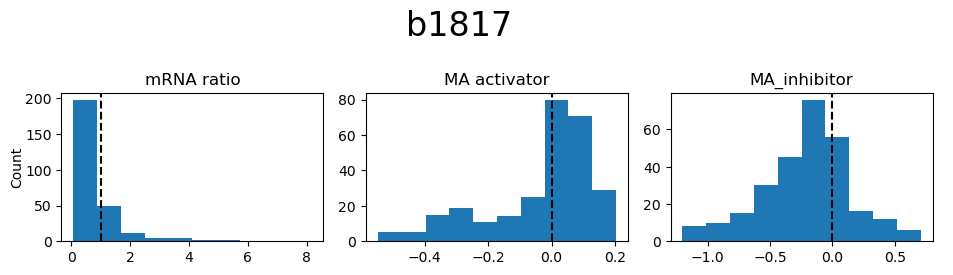

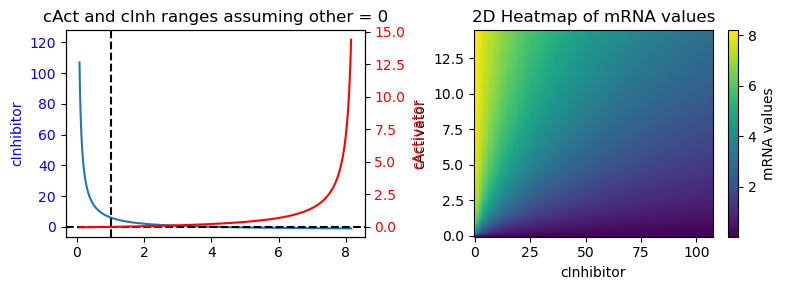

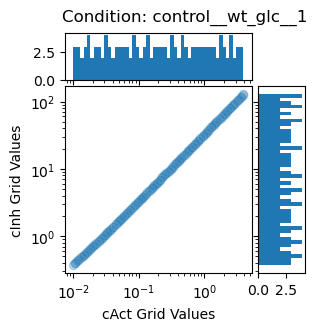

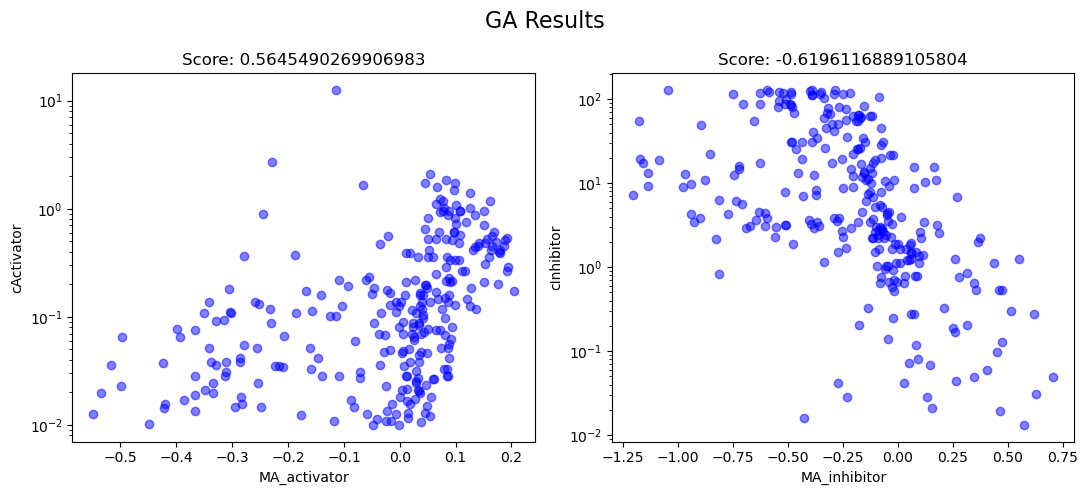

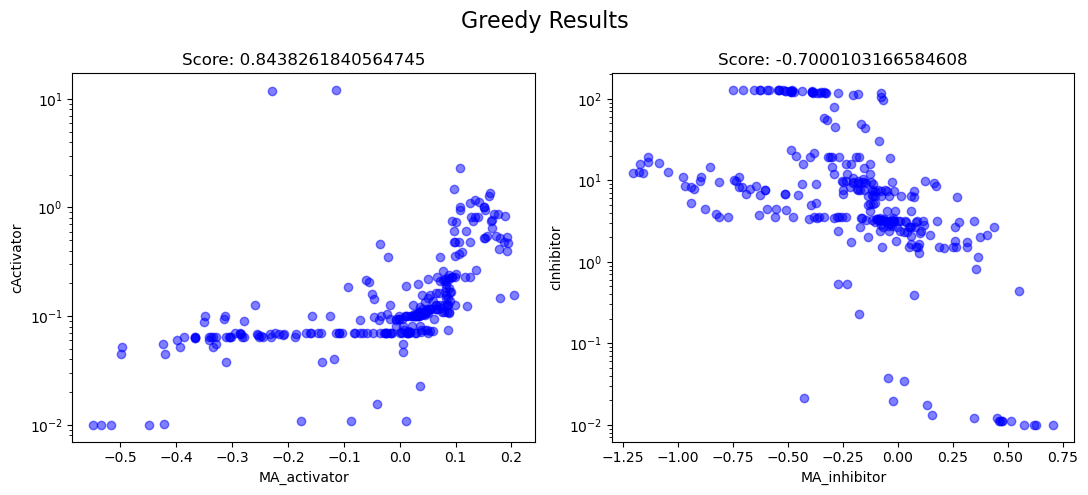

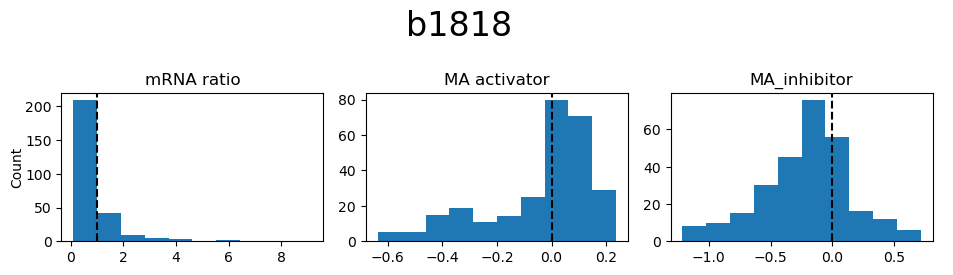

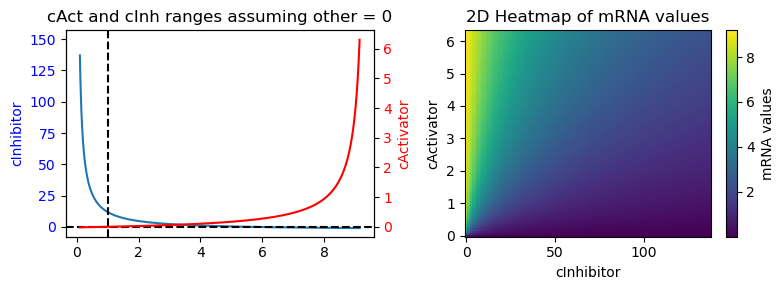

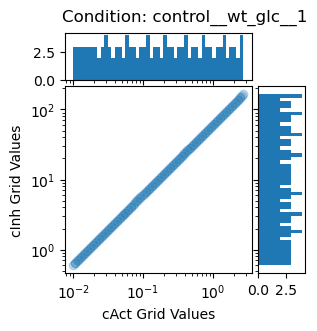

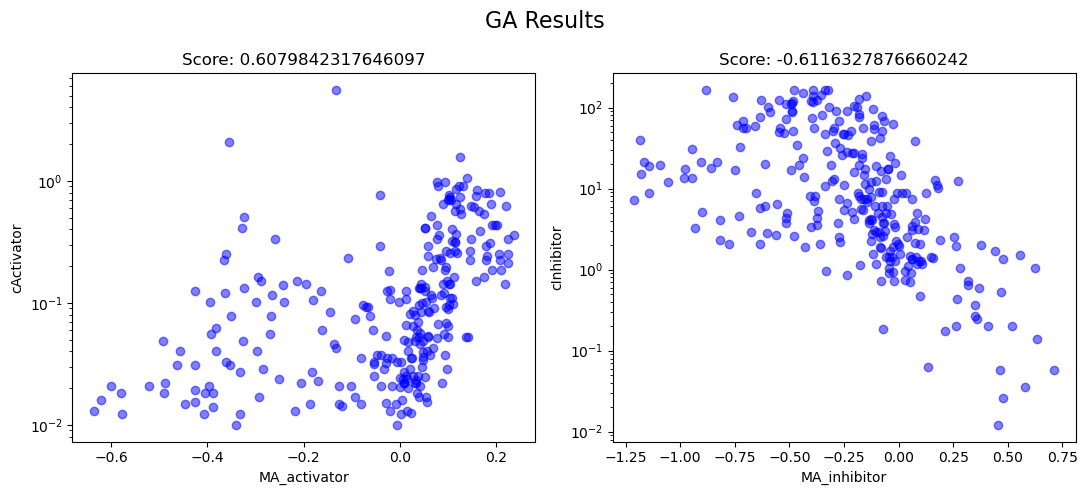

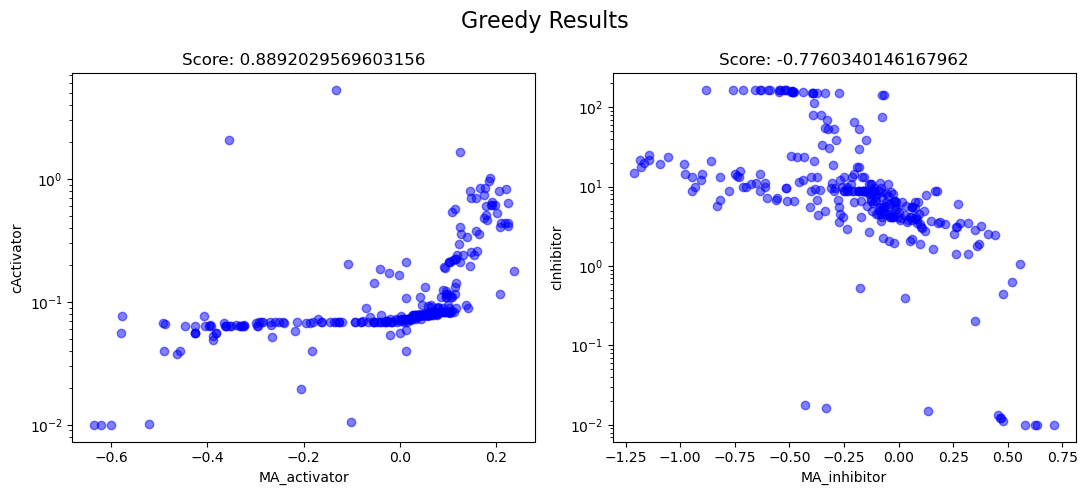

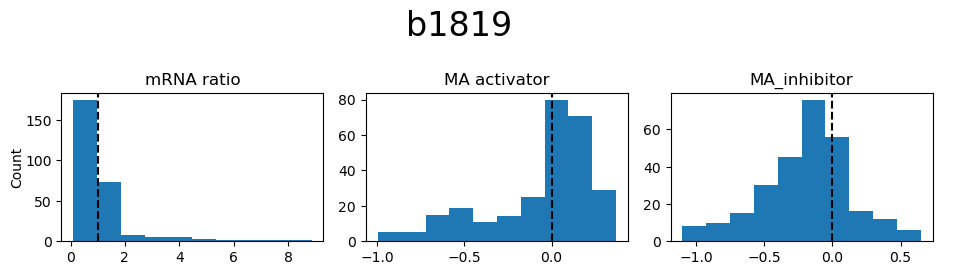

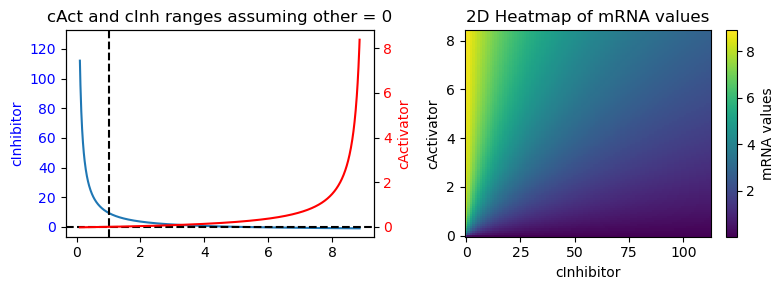

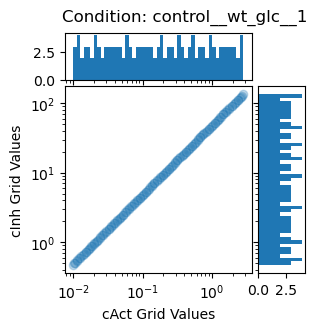

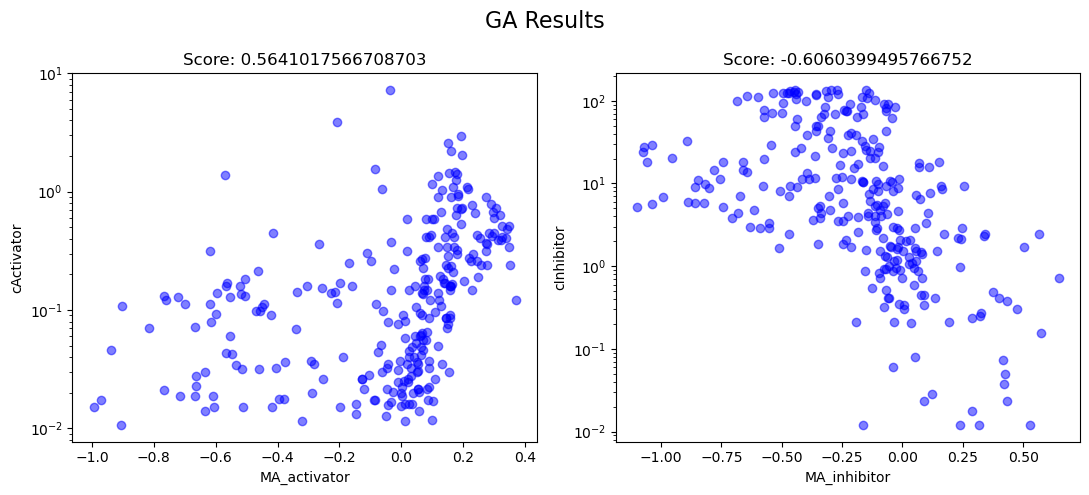

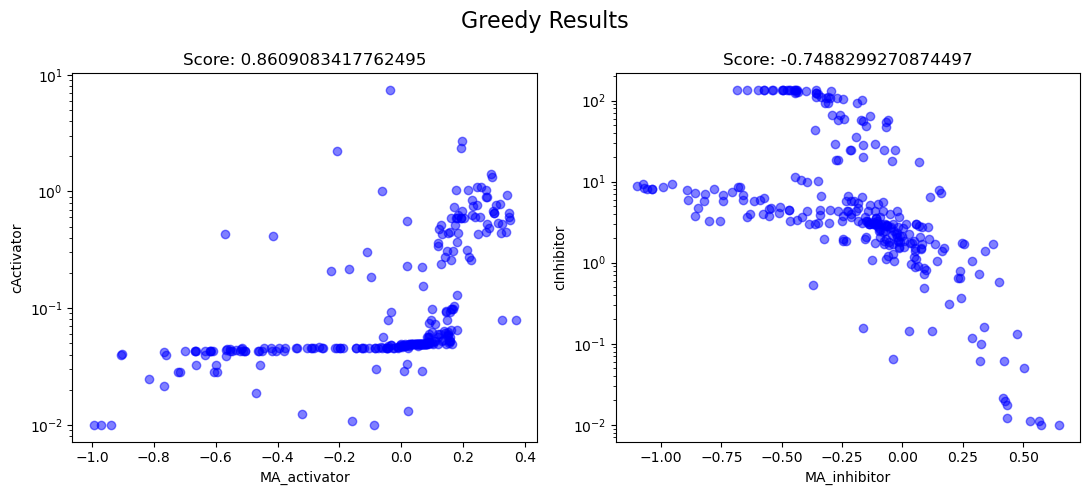

In [61]:
# display gene specific results
for gene, result in zip(genes, results):
    result[0].suptitle(gene, fontsize = 24)
    result[0].tight_layout()
    for res in result:
        show_figure(res)
        #display(plt.gcf())

In [50]:
# run GAMs
if flags['force_rerun']:
    iG.run_GAMs(flags, 'b3357', 'b1594', flags['cell_constants'])

--- Job combined_model Start 11/08/23 14:33:25 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/combined_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- combined_model.gms(23) 3 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cAct index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input_cAct.gdx
--- combined_

    266   4        1.5180936340E+02 1.1E+01   420 1.0E+00    1 F  T
    271   4        1.4938006074E+02 9.0E+00   420 2.3E+00    1 F  T
    276   4        1.4821067998E+02 1.4E+01   419 1.5E-02    1 F  T
    281   4        1.4793785481E+02 9.0E+00   418 1.0E+00    1 F  T
    286   4        1.4778466091E+02 4.8E+00   416 4.0E+00    1 F  T
    291   4        1.4749016563E+02 9.0E+00   415 1.0E+00    1 F  T
    301   4        1.4703450989E+02 4.8E+00   412 1.7E-01      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    306   4        1.4687761561E+02 5.9E+00   412 1.4E-03    1 F  T
    311   4        1.4675010690E+02 4.8E+00   410 1.2E-01      F  T
    316   4        1.4666780941E+02 4.4E+00   410 6.3E-04    1 F  T
    321   4        1.4662249273E+02 9.0E+00   410 1.6E-03    1 F  T
    331   4        1.4655071747E+02 8.3E+00   409 8.3E-04    1 F  T
    336   4        1.4654072840E+02 5.6E+00   409 8.2E-05    1 F  T
    341   4        1.4653082075E+02 6.3E+00  

    901   4        1.3043257487E+02 9.8E+00   355 1.7E-03      F  T
    906   4        1.3043209037E+02 6.3E+00   354 3.7E-07    1 F  T
    911   4        1.3043155754E+02 4.7E+00   353 3.0E-06    1 F  T
    921   4        1.3043085665E+02 8.4E+00   351 1.4E-03      F  T
    931   4        1.3043023520E+02 9.0E+00   350 4.9E-06    1 F  T
    941   4        1.3042886926E+02 4.5E+00   349 4.7E-03      F  T
    946   4        1.3042822694E+02 5.7E+00   349 1.7E-06    1 F  T
    951   4        1.3042798863E+02 1.5E+01   348 6.0E-01    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    961   4        1.3042711260E+02 4.7E+00   347 1.1E-05    1 F  T
    966   4        1.3042701770E+02 5.6E+00   346 9.2E-07    1 F  T
    971   4        1.2979521036E+02 5.9E+01   375 2.3E+00    1 F  T
    976   4        1.2905815168E+02 5.1E+01   373 3.6E+00    1 F  T
    981   4        1.2432227976E+02 1.9E+01   370 4.2E-01      F  T
    991   4        1.2235926325E+02 2.9E+01  

   1591   4        1.1972527867E+02 9.4E+00   287 1.9E-08    1 F  T
   1601   4        1.1925794078E+02 6.6E+01   307 2.0E-02      F  T
   1606   4        1.1916675880E+02 5.1E+01   306 1.7E+02    1 F  T
   1611   4        1.1894586325E+02 1.3E+01   305 2.3E+00    1 F  T
   1616   4        1.1882713637E+02 2.2E+01   303 1.0E+00    1 F  T
   1621   4        1.1872442152E+02 1.6E+01   302 1.5E+01    1 F  T
   1626   4        1.1858397874E+02 9.2E+00   301 1.0E+00    1 F  T
   1631   4        1.1854378981E+02 9.2E+00   300 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   1636   4        1.1850606865E+02 9.2E+00   298 3.0E-03    1 F  T
   1641   4        1.1847632250E+02 7.3E+00   297 8.2E-04    1 F  T
   1651   4        1.1846039705E+02 2.1E+01   294 1.4E-02      F  T
   1661   4        1.1845305574E+02 3.0E+01   291 2.4E-03      F  T
   1666   4        1.1844949884E+02 3.0E+01   289 3.9E+01    1 F  T
   1671   4        1.1844668826E+02 7.6E+00  

   2291   4        1.1620345088E+02 1.1E+01   221 6.4E-03      F  T
   2296   4        1.1620248244E+02 2.0E+01   221 7.0E-01    1 F  T
   2301   4        1.1620205139E+02 1.0E+01   220 1.0E+00    1 F  T
   2311   4        1.1620072344E+02 1.1E+01   218 1.3E-03      F  T
   2316   4        1.1620037458E+02 9.3E+00   216 2.3E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2321   4        1.1620007000E+02 1.5E+01   214 1.0E+00    1 F  T
   2326   4        1.1619979323E+02 1.5E+01   213 2.8E+00    1 F  T
   2331   4        1.1619958430E+02 6.1E+00   212 6.9E-01    1 F  T
   2341   4        1.1619883126E+02 1.0E+01   211 4.3E-06    1 F  T
   2346   4        1.1619840589E+02 2.0E+01   210 6.6E-01    1 F  T
   2351   4        1.1619775103E+02 1.5E+01   210 5.7E-01    1 F  T
   2356   4        1.1619705308E+02 9.2E+00   210 6.4E-06    1 F  T
   2361   4        1.1619654445E+02 1.3E+01   208 9.7E-03      F  T
   2371   4        1.1619597663E+02 1.2E+01  

   2981   4        1.1572756106E+02 5.2E+00   145 2.9E-05      F  T
   2986   4        1.1572755650E+02 5.2E+00   144 3.2E-08    1 F  T
   2991   4        1.1572616879E+02 2.5E+01   165 1.0E+00    1 F  T
   2996   4        1.1572545561E+02 1.4E+01   163 1.0E+00    1 F  T
   3001   4        1.1572500516E+02 4.1E+01   129 3.7E+01    1 F  T
   3006   4        1.1572456294E+02 2.0E+01   134 2.4E+01    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3011   4        1.1572373259E+02 1.6E+01   158 2.0E+00    1 F  T
   3021   4        1.1560591529E+02 4.4E+01   156 5.1E-02      F  T
   3026   4        1.1559888001E+02 1.7E+01   156 1.0E+00    1 F  T
   3031   4        1.1559659103E+02 9.3E+00   155 7.2E-02      F  T
   3041   4        1.1559519357E+02 1.0E+01   152 2.1E-02      F  T
   3051   4        1.1559431012E+02 1.4E+01   151 1.0E+00    1 F  T
   3061   4        1.1559372174E+02 1.4E+01   150 5.8E+01    1 F  T
   3066   4        1.1559339071E+02 1.8E+01  

   3651   4        1.1558921250E+02 2.2E+01   112 1.6E+01    1 F  T
   3661   4        1.1558901190E+02 2.0E+01   108 1.1E-05      F  T
   3666   4        1.1558896000E+02 1.1E+01   104 2.2E+00    1 F  T
   3671   4        1.1558892502E+02 4.5E+01   104 5.2E-05      F  T
   3681   4        1.1558881474E+02 2.8E+01   102 1.7E+02    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3686   4        1.1558876916E+02 1.5E+01   101 5.1E-06    1 F  T
   3691   4        1.1558875814E+02 1.7E+01    99 3.4E-03      F  T
   3696   4        1.1558874877E+02 1.7E+01    99 9.1E+00    1 F  T
   3701   4        1.1558873684E+02 9.2E+00    98 5.7E-03      F  T
   3706   4        1.1558872830E+02 9.2E+00    97 3.9E-06    1 F  T
   3711   4        1.1558871759E+02 2.6E+01    95 9.3E+00    1 F  T
   3721   4        1.1558870907E+02 9.2E+00    95 8.2E-03      F  T
   3726   4        1.1558870742E+02 1.1E+01    95 1.6E+02    1 F  T
   3731   4        1.1558870004E+02 1.2E+01  

   4281   4        1.1558725535E+02 1.5E+01    77 7.1E-06    1 F  T
   4286   4        1.1558723761E+02 1.5E+01    76 4.4E+00    1 F  T
   4291   4        1.1558723411E+02 1.1E+01    76 1.5E-05      F  T
   4296   4        1.1558722562E+02 1.1E+01    76 4.1E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   4301   4        1.1558721682E+02 9.1E+00    75 1.8E-07    1 F  T
   4311   4        1.1558720961E+02 9.2E+00    75 1.7E-05      F  T
   4316   4        1.1558720355E+02 9.2E+00    43 2.7E+01    1 F  T
   4321   4        1.1558719864E+02 2.2E+01    43 1.2E+00    1 F  T
   4331   4        1.1558719581E+02 9.0E+00    74 1.2E-07      F  T
   4336   4        1.1558718448E+02 1.5E+01    72 2.0E+01    1 F  T
   4341   4        1.1558717429E+02 1.7E+01    72 2.0E+01    1 F  T
   4346   4        1.1558716306E+02 1.5E+01    71 3.2E-07    1 F  T
   4351   4        1.1558715983E+02 5.9E+00    70 8.9E-06      F  T
   4361   4        1.1558715479E+02 9.4E+00  

   4911   4        1.1558491403E+02 7.7E+00    52 5.6E-12      F  T
   4916   4        1.1558491403E+02 4.6E+00    52 9.1E-11    1 F  T
   4921   4        1.1558491403E+02 8.6E+00    51 1.5E-01    1 F  T
   4931   4        1.1558491401E+02 8.3E+00    51 8.0E-12    1 F  T
   4941   4        1.1558491401E+02 4.8E+00    51 1.5E-11      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   4946   4        1.1558491401E+02 9.4E+00    51 1.5E-02    1 F  T
   4951   4        1.1558491401E+02 7.9E+00    51 4.0E-01    1 F  T
   4956   4        1.1558491401E+02 5.6E+00    51 2.3E-01    1 F  T
   4961   4        1.1558491401E+02 4.6E+00    51 7.5E-07      F  T
   4966   4        1.1558491401E+02 9.4E+00    51 4.5E-01    1 F  T
   4971   4        1.1558491401E+02 4.6E+00    51 1.7E-01    1 F  T
   4976   4        1.1558491401E+02 4.6E+00    51 2.3E-02    1 F  T
   4981   4        1.1558491398E+02 9.3E+00    75 9.4E-08      F  T
   4991   4        1.1558379837E+02 1.7E+01  

   5581   4        1.1402963471E+02 9.0E+00    44 5.1E-12    1 F  T
   5586   4        1.1402963471E+02 6.6E+00    43 3.2E-12    1 F  T
   5591   4        1.1402963471E+02 6.6E+00    42 5.2E-11      F  T
   5601   4        1.1400847325E+02 2.1E+01    76 1.0E+00    1 F  T
   5606   4        1.1387455305E+02 2.0E+01    74 2.6E+00    1 F  T
   5611   4        1.1373146090E+02 3.4E+01    72 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   5616   4        1.1361813010E+02 1.8E+01    72 3.2E-03    1 F  T
   5621   4        1.1340123757E+02 3.5E+01    70 7.5E-02      F  T
   5631   4        1.1319789181E+02 1.2E+01    67 1.0E+00    1 F  T
   5641   4        1.1316131280E+02 1.7E+01    64 2.5E+01    1 F  T
   5646   4        1.1315776966E+02 1.6E+01    63 2.2E+00    1 F  T
   5651   4        1.1315630023E+02 1.7E+01    62 2.2E+00    1 F  T
   5656   4        1.1315567793E+02 1.7E+01    61 7.1E+00    1 F  T
   5661   4        1.1315422585E+02 1.1E+01  

   6266   4        1.1178339626E+02 3.2E+01    97 6.7E-01    1 F  T
   6271   4        1.1135485307E+02 9.9E+00    97 2.0E+00    1 F  T
   6281   4        1.0853907241E+02 6.4E+01    93 6.9E-02      F  T
   6286   4        1.0772602378E+02 4.9E+01    92 1.0E+00    1 F  T
   6291   4        1.0733850909E+02 9.1E+00    91 6.1E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   6296   4        1.0681953264E+02 9.4E+00    90 1.0E+00    1 F  T
   6301   4        1.0648132703E+02 1.5E+01    94 4.2E+00    1 F  T
   6306   4        1.0634542035E+02 9.1E+00    92 2.8E-03    1 F  T
   6311   4        1.0628076648E+02 6.2E+01    89 2.0E-02      F  T
   6321   4        1.0611314571E+02 2.3E+01    86 1.7E+00    1 F  T
   6326   4        1.0605637513E+02 1.0E+01    89 1.4E+01    1 F  T
   6331   4        1.0602943691E+02 1.0E+01    89 1.4E-03    1 F  T
   6341   4        1.0598024165E+02 1.0E+01    85 1.9E-01      F  T
   6346   4        1.0595371076E+02 3.5E+01  

   6951   4        1.0548041520E+02 9.6E+00    34 3.6E-05      F  T
   6961   4        1.0548040886E+02 4.6E+00    34 3.1E-07    1 F  T
   6966   4        1.0548040627E+02 8.8E+00    34 7.2E+00    1 F  T
   6971   4        1.0548040512E+02 4.5E+00    34 6.9E-08    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   6976   4        1.0548040485E+02 9.4E+00    11 1.1E+01    1 F  T
   6981   4        1.0548040456E+02 4.8E+00    33 1.0E-06      F  T
   6986   4        1.0548035165E+02 9.4E+00    33 4.9E-02    1 F  T
   6991   4        1.0547875833E+02 1.4E+01    33 1.0E-06    1 F  T
   6996   4        1.0547874172E+02 2.2E+01    11 3.2E+00    1 F  T
   7001   4        1.0547866334E+02 2.3E+01    33 5.6E+00    1 F  T
   7006   4        1.0547864008E+02 9.6E+00    33 1.1E-06    1 F  T
   7011   4        1.0547863604E+02 9.4E+00    33 1.0E+00    1 F  T
   7016   4        1.0547863199E+02 9.6E+00    31 2.5E-07    1 F  T
   7021   4        1.0547863073E+02 4.2E+00  

   7611   4        1.0466361030E+02 4.8E+00    39 5.6E-01    1 F  T
   7621   4        1.0466350841E+02 7.1E+00    38 2.3E-03      F  T
   7626   4        1.0466350245E+02 7.0E+00    18 1.0E+00    1 F  T
   7631   4        1.0466349557E+02 4.8E+00    18 1.9E+01    1 F  T
   7636   4        1.0466348711E+02 1.1E+01    38 5.3E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   7641   4        1.0466348315E+02 4.8E+00    24 1.0E+00    1 F  T
   7651   4        1.0466347445E+02 4.8E+00    36 5.4E-06      F  T
   7656   4        1.0466347361E+02 8.1E+00    35 2.4E-07    1 F  T
   7661   4        1.0466347306E+02 4.8E+00    15 4.0E+02    1 F  T
   7666   4        1.0466347185E+02 4.8E+00    35 1.2E+01    1 F  T
   7671   4        1.0466347077E+02 1.7E+01    34 4.6E-08    1 F  T
   7676   4        1.0466347040E+02 6.8E+00    33 6.2E-08    1 F  T
   7681   4        1.0466347015E+02 7.0E+00    32 2.0E-10      F  T
   7686   4        1.0466347012E+02 7.7E+00  

   8291   4        1.0409032845E+02 5.9E+00    43 1.3E+01    1 F  T
   8296   4        1.0408930456E+02 4.7E+00    43 1.7E-04    1 F  T
   8301   4        1.0408886988E+02 5.9E+00    42 3.1E+01    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   8306   4        1.0408818422E+02 1.3E+01    41 7.9E-06    1 F  T
   8311   4        1.0408809041E+02 1.0E+01    39 2.8E-01      F  T
   8321   4        1.0408794841E+02 1.0E+01    39 2.0E+01    1 F  T
   8326   4        1.0408779779E+02 2.4E+01    39 6.2E-06    1 F  T
   8331   4        1.0408779748E+02 4.8E+00    39 1.4E-08      F  T
   8341   4        1.0408760543E+02 1.5E+01    37 6.0E+01    1 F  T
   8346   4        1.0408751841E+02 1.7E+01    37 8.9E-07    1 F  T
   8351   4        1.0408746126E+02 1.0E+01    35 1.1E-06    1 F  T
   8356   4        1.0408745621E+02 5.9E+00    35 8.7E+00    1 F  T
   8361   4        1.0408745294E+02 1.5E+01    15 1.4E+02    1 F  T
 
   Iter Phase Ninf     Objective     RGmax 

   9001   4        1.0396379003E+02 3.6E+01    18 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   9006   4        1.0396297868E+02 2.4E+01    22 6.7E+01    1 F  T
   9011   4        1.0396258072E+02 1.7E+01    33 2.8E+01    1 F  T
   9016   4        1.0396235645E+02 1.2E+01    33 1.5E+01    1 F  T
   9021   4        1.0396228087E+02 1.1E+01    32 1.8E-05    1 F  T
   9031   4        1.0396213982E+02 5.9E+00    31 2.4E-05    1 F  T
   9036   4        1.0396204724E+02 4.7E+00    29 2.2E-05    1 F  T
   9041   4        1.0396201893E+02 1.1E+01    28 3.5E-06      F  T
   9051   4        1.0396199715E+02 7.9E+00    27 5.5E-07      F  T
   9056   4        1.0396199354E+02 8.1E+00    27 7.0E-08    1 F  T
   9061   4        1.0396199341E+02 4.8E+00     9 7.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   9066   4        1.0396199301E+02 5.9E+00    27 5.8E-08    1 F  T
   9071   4        1.0396199293E+02 5.9E+0

   9711   4        1.0385993115E+02 1.4E+01    30 5.1E-07    1 F  T
   9721   4        1.0385992949E+02 8.1E+00    25 5.2E-08    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   9726   4        1.0385986570E+02 8.1E+00    23 1.8E-08    1 F  T
   9731   4        1.0385986536E+02 1.3E+01    23 5.4E-11      F  T
   9741   4        1.0385986518E+02 4.9E+00    23 3.3E-08    1 F  T
   9746   4        1.0385986517E+02 4.7E+00    22 2.3E-09    1 F  T
   9751   4        1.0385983916E+02 2.4E+01    23 7.1E+00    1 F  T
   9756   4        1.0385965865E+02 2.3E+01    39 2.8E+00    1 F  T
   9761   4        1.0385945914E+02 2.0E+01    37 1.2E+01    1 F  T
   9771   4        1.0385924576E+02 2.5E+01    37 6.8E+00    1 F  T
   9776   4        1.0385912159E+02 9.3E+00    37 1.1E-05    1 F  T
   9781   4        1.0385908069E+02 1.8E+01    36 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   9786   4        1.0385896941E+02 2.3E+0

  10371   4        1.0284763623E+02 1.6E+01    37 8.2E-06      F  T
  10376   4        1.0284763014E+02 1.7E+01    36 4.6E-07    1 F  T
  10381   4        1.0284762721E+02 8.5E+00    35 6.2E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
  10386   4        1.0284762362E+02 1.5E+01    22 1.0E+00    1 F  T
  10391   4        1.0284757250E+02 1.6E+01    21 2.2E+01    1 F  T
  10396   4        1.0284755597E+02 1.3E+01    32 7.8E-07    1 F  T
  10401   4        1.0284755197E+02 8.5E+00    33 1.8E-07    1 F  T
  10406   4        1.0284755008E+02 9.9E+00    33 1.2E+01    1 F  T
  10411   4        1.0284754658E+02 8.7E+00    37 3.0E-07    2 F  T
  10416   4        1.0284754489E+02 8.4E+00    37 3.1E-07    1 F  T
  10421   4        1.0284754461E+02 4.7E+00    36 5.8E-02    1 F  T
  10426   4        1.0284754116E+02 9.4E+00    35 1.0E+00    1 F  T
  10431   4        1.0284754075E+02 8.5E+00    34 1.1E-08    1 F  T
 
   Iter Phase Ninf     Objective     RGmax 

  11021   4        1.0262071152E+02 1.0E+01    26 1.7E+02    1 F  T
  11026   4        1.0262037538E+02 1.3E+01    25 5.9E+00    1 F  T
  11031   4        1.0262031203E+02 9.4E+00    24 4.8E-01      F  T
  11036   4        1.0262026281E+02 1.4E+01    23 3.5E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
  11041   4        1.0262023353E+02 1.7E+01    20 7.3E+00      F  T
  11051   4        1.0262007284E+02 9.4E+00    16 6.5E+00    1 F  T
  11056   4        1.0261864331E+02 4.1E+01    15 5.8E+01    1 F  T
  11061   4        1.0261623064E+02 9.5E+00    16 2.0E-01      F  T
  11071   4        1.0260076166E+02 2.0E+01    14 2.0E+01    1 F  T
  11076   4        1.0260020739E+02 2.4E+01    14 9.2E-06    1 F  T
  11081   4        1.0260001942E+02 1.7E+01    14 6.3E-06    1 F  T
  11086   4        1.0259999474E+02 9.3E+00    10 6.4E+00    1 F  T
  11091   4        1.0259997781E+02 9.5E+00    10 1.5E+01    1 F  T
  11096   4        1.0259996358E+02 1.0E+01  

  11681   4        1.0246482600E+02 2.4E+01     4 8.9E-11      F  T
  11686   4        1.0246482575E+02 9.3E+00     6 1.9E+01    1 F  T
  11691   4        1.0246482530E+02 1.2E+01     5 1.3E-08    1 F  T
  11696   4        1.0246482519E+02 4.8E+00     5 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
  11701   4        1.0246482518E+02 3.3E+00     5 1.3E-10      F  T
  11711   4        1.0246482507E+02 1.2E+01     6 5.2E-07    1 F  T
  11716   4        1.0246482503E+02 1.2E+01     5 3.8E-09    1 F  T
  11721   4        1.0246482502E+02 5.9E+00     5 5.3E-10    1 F  T
  11726   4        1.0246482479E+02 2.4E+01     6 1.0E+00    1 F  T
  11731   4        1.0246482478E+02 2.4E+01     6 1.0E+00    1 F  T
  11736   4        1.0246482389E+02 7.9E+00     6 2.0E-09    1 F  T
  11741   4        1.0246482385E+02 1.5E+01     5 2.5E-12      F  T
  11751   4        1.0246482378E+02 4.8E+00     6 1.6E-08    1 F  T
  11756   4        1.0246482374E+02 2.2E+01  

/tmp/ipykernel_1453451/3992264881.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1453451/3992264881.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


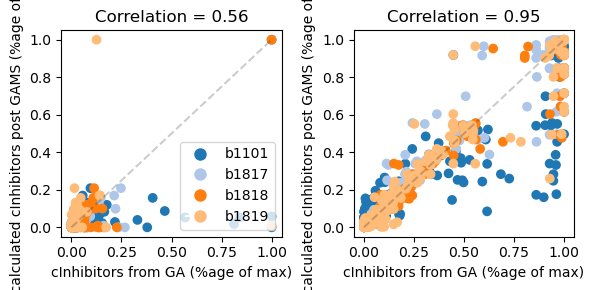

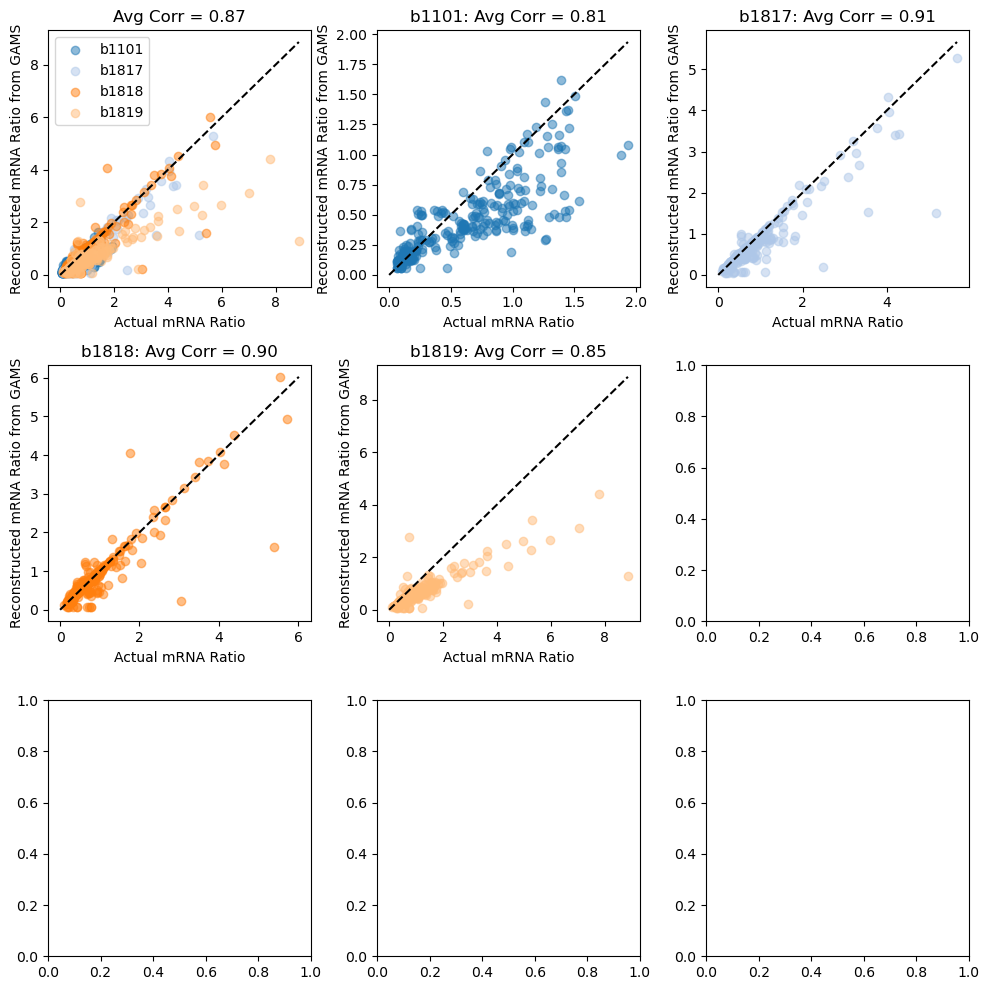

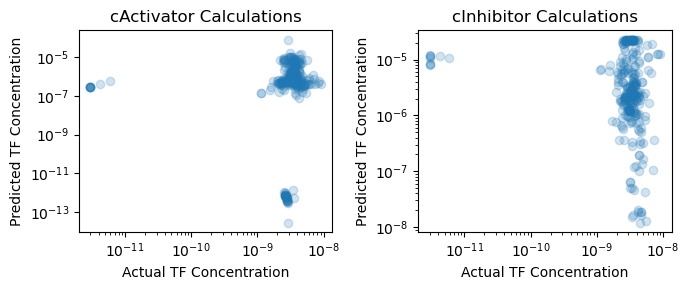

In [92]:
# read and display GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(flags)
if flags['sanity_plots']:
    # look at GAMs results
    scale_to_100_perc = True # scale cAct / cInh by 100%

    # load in cActivators
    saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cAct_vals.csv', index_col = 0)

    # GAMS calculated cActivators
    kd_df = 10**pd.read_csv('../data/GAMS_output/cAct_Kd_results.csv', index_col = 0).astype(float).T
    saved_cActivators = saved_cActivators[kd_df.columns]
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
    calc_cAct = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
    cActs = []
    for sample in calc_cAct.columns:
        for gene in calc_cAct.index:
            calc_cAct.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
    calc_cAct = calc_cAct.T


    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cAct.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cAct.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cAct.loc[sample][gene] / max(calc_cAct[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cAct.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    fig, axs = plt.subplots(1, 2, figsize = (6, 3))
    scatter = axs[0].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[0].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[0].set_xlabel('cInhibitors from GA (%age of max)')
        axs[0].set_ylabel('Recalculated cInhibitors post GAMS (%age of max)')
    else:
        axs[0].set_xlabel('cActivators from GA')
        axs[0].set_ylabel('Recalculated cActivators post GAMS')
    corr = np.corrcoef(saved, calc)
    axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')

    # Create an empty list to store legend handles and labels
    legend_elements = []
    for label, color in gene_to_color.items():
        legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
    axs[0].legend(handles = legend_elements, loc = 'lower right')


    # now plot cInhibitor
    # load in cActivators
    saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cInh_vals.csv', index_col = 0)

    # GAMS calculated cActivators
    kd_df = 10**pd.read_csv('../data/GAMS_output/cInh_Kd_results.csv', index_col = 0).astype(float).T
    saved_cActivators = saved_cActivators[kd_df.columns]
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
    calc_cInh = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
    cActs = []
    for sample in calc_cInh.columns:
        for gene in calc_cInh.index:
            calc_cInh.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
    calc_cInh = calc_cInh.T

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cInh.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cInh.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cInh.loc[sample][gene] / max(calc_cInh[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cInh.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    scatter = axs[1].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[1].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[1].set_xlabel('cInhibitors from GA (%age of max)')
        axs[1].set_ylabel('Recalculated cInhibitors post GAMS (%age of max)')
    else:
        axs[1].set_xlabel('cInhibitors from GA')
        axs[1].set_ylabel('Recalculated cInhibitors post GAMS')
    corr = np.corrcoef(saved, calc)
    axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')
    fig.tight_layout()
    plt.show()

    
    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    recons_mRNAs = []
    indices_for_recons = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    for gene in calc_cAct.columns:
        # load grid constants
        gene_grid_name = '../data/gene_grid_constants/'+gene+'.pkl'
        pickle_in = open(gene_grid_name, 'rb')
        grid = pickle.load(pickle_in)
        pickle_in.close()
        
        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        # setup
        po.create_shared_lambda_df(flags['eq_str'], grid)
        
        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)
    
        actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.tight_layout()
    plt.show()
    
    
    
    # TF conc values
    # histogram of TF_conc values
    actual_TF_conc_df = pd.read_csv('../data/save_for_GAMs/exported_act_TF_conc.csv', index_col = 0)
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(actual_TF_conc.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    actual_TF_conc_df = pd.read_csv('../data/save_for_GAMs/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(actual_TF_conc.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()
    

    # save recon
    recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = shared)

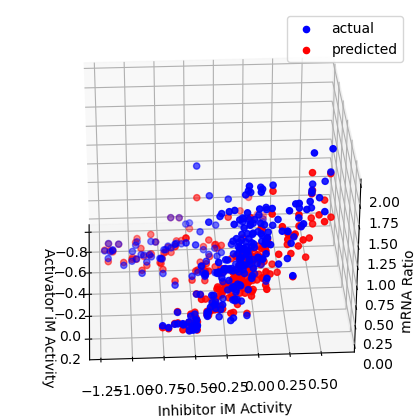

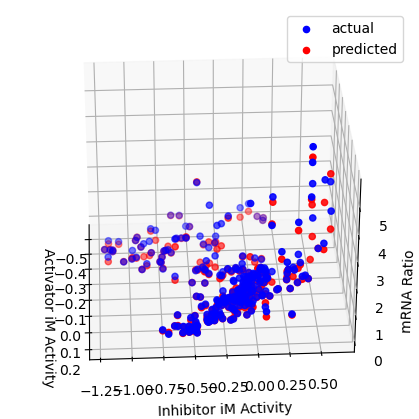

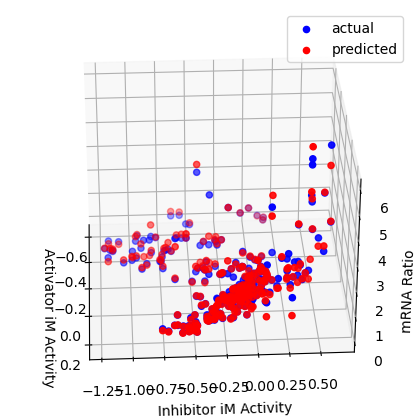

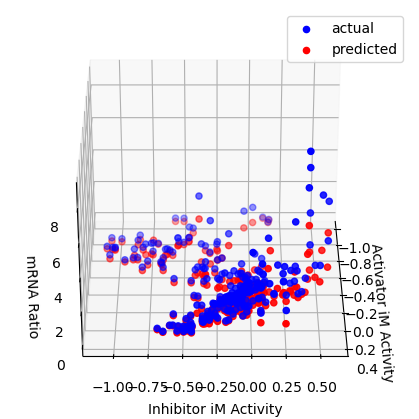

In [35]:
# 3D plot of iModulons and mRNA ratios
# 3D plot their mRNA values along the phase planes
shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    
    
#plt.rcParams["figure.dpi"] = 300
#matplotlib.rcParams['pdf.fonttype'] = 42
#sns.set_palette("deep")
#sns.set_context("paper")
#sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols

for gene in genes:
    fig = plt.figure(figsize = (4, 4))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    
    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

    ax.scatter(ratios_df.loc[shared]['MA_activator'], ratios_df.loc[shared]['MA_inhibitor'], ratios_df['actual_mRNA_ratio'].loc[shared], color = 'blue', label = 'actual')
    ax.scatter(ratios_df.loc[shared]['MA_activator'], ratios_df.loc[shared]['MA_inhibitor'], recon_df[shared].loc[gene], color = 'red', label = 'predicted')

    ax.set_xlabel('Activator iM Activity')
    ax.set_ylabel('Inhibitor iM Activity')
    ax.set_zlabel('mRNA Ratio')
    plt.legend()

    # this function defines the animation action done to the plot
    def rotate(angle):
         ax.view_init(azim=angle)

    angle = 3
    ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
    ani.save('../figures/'+gene+'.gif', writer=animation.PillowWriter(fps=10))

# depreceated - creation of the pipeline (leave here for now)

In [10]:
# import statements
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import display
import multiprocessing

import sys
sys.path.insert(0, '../functions/')
import basal_model_calcs as bmc
import mRNA_ratios as mr
import parameter_optimization as po
import create_cAct_cInh_vals as cv
import interface_GAMS as iG

In [2]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : True,
    'sanity_plots' : True,
    'central_gene' : 'b1819',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.1, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.1, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.10, # add this %age of the maximum to the top
    'cActivator' : [-2,2], # Uses a log10 range
    'cInhibitor': [-2,2], # Uses a log10 range
    'run_greedy' : False, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'use_greedy' : False, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'] # if run_on_all is False, limit to these samples (or which of them are available)
}


gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
t_half_life_deg = 300
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    #'KeqOpening': 10**-0.34444956947383365, gets set later
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'k_d_TF': 1, # May change depending on model
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
}

eq_str = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))'

gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if os.path.exists(gene_grid_name):
    pickle_in = open(gene_grid_name, 'rb')
    gene_grid_constants = pickle.load(pickle_in)
    pickle_in.close()
else:
    gene_grid_constants = {}
    
# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

# collect figures
gene_figs = []
together_figs = []

In [3]:
# to do
# 1 - add sanity plots, likely collected throughout
# 2 - better enforce flags['force_rerun'] to save runtime
# 3 - put "per every gene" functions into one function
# 4 - figure out scaled TF concentration

## per every gene

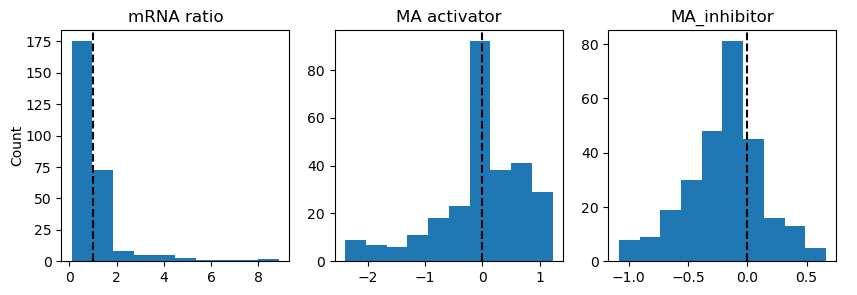

In [4]:
# create mRNA ratios and MA values
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mr.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)
if flags['sanity_plots']:
    # sanity check plot
    fig, axs = plt.subplots(1, 3, figsize = (10, 3))
    axs[0].hist(ratios_df.actual_mRNA_ratio)
    axs[0].set_title('mRNA ratio')
    axs[0].axvline(x = 1, c = 'k', ls = '--')
    axs[1].hist(ratios_df.MA_activator)
    axs[1].set_title('MA activator')
    axs[1].axvline(x = 0, c = 'k', ls = '--')
    axs[2].hist(ratios_df.MA_inhibitor)
    axs[2].set_title('MA_inhibitor')
    axs[2].axvline(x = 0, c = 'k', ls = '--')
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel('Count')
    gene_figs.append(fig)
    #plt.show()

In [5]:
# create TF concentration # TODO, CHECK THIS
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
scaled_df = 2**log_tpm_df / (2**log_tpm_df).sum()

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df.loc['b3357'].to_csv('../data/save_for_GAMs/exported_TF_conc.csv')

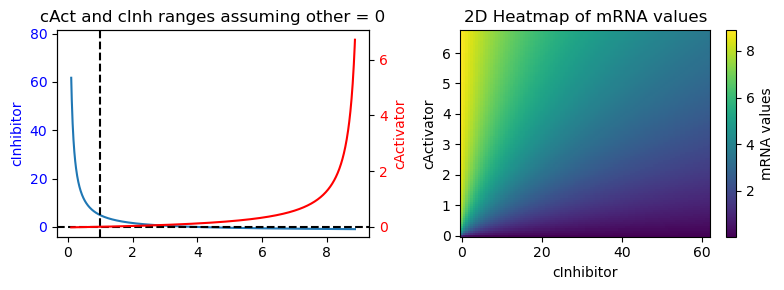

In [6]:
# pick KdRNAPCrp value, limit cActivator and cInhibitor based on it
# load in calculator
gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if flags['force_rerun'] or not os.path.exists(gene_grid_name):  
    # basal model calculations
    grid_constants = bmc.basal_values(grid_constants, eq_str, flags)
    
    # pick KdRNAPCrp
    po.create_shared_lambda_df(eq_str, grid_constants)
    grid_constants['KdRNAPCrp'] = po.pick_KdRNAPCrp(ratios_df, flags)

    # save off grid constants
    pickle_out = open(gene_grid_name, 'wb')
    pickle.dump(grid_constants, pickle_out)
    pickle_out.close()
else:
    pickle_in = open(gene_grid_name, 'rb')
    grid_constants = pickle.load(gene_grid_name)
    pickle_in.close()
if flags['sanity_plots']:
    # sanity check plot

    # if you get weird results here, look at egulonML/parameter_optimization/0_framework.ipynb
    # it does the same thing as the function with plots along the way
    # try adjusting the initial guess for the first optimization
    # that is line 74 of functions/parameter_optimization.py

    # however, it is a sanity check to see if these values are near-correct
    rat_vals = np.linspace(min(ratios_df['actual_mRNA_ratio'].values.flatten()), max(ratios_df['actual_mRNA_ratio'].values.flatten()), 1000)

    cInh_vals = [po.mRNA_cActivator_to_cInhibitor(rat_val, flags['base_cActivator_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]
    cAct_vals = [po.mRNA_cInhibitor_to_cActivator(rat_val, flags['base_cInhibitor_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]

    fig, axs = plt.subplots(1, 2, figsize = (8, 3))
    ax1 = axs[0]
    l1, = ax1.plot(rat_vals, cInh_vals)
    plt.xlabel('mRNA Ratio')
    ax1.set_ylabel('cInhibitor', color = 'blue')
    ax1.tick_params(axis = 'y', labelcolor = 'blue')
    ax2 = ax1.twinx()
    l2, = ax2.plot(rat_vals, cAct_vals, color = 'red')
    ax2.set_ylabel('cActivator', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax1.axhline(y = 0, ls = '--', c = 'k')
    ax1.axvline(x = 1, ls = '--', c = 'k')
    # let's rescale cInhibitor (ax1) so that 0 is at the same point
    m1, M1 = ax1.get_ylim()
    percent1_up = (0 - m1) / (M1 - m1)
    m2, M2 = ax2.get_ylim()
    percent2_up = (0 - m2) / (M2 - m2)

    if percent1_up < percent2_up:
        # zero is higher than it should, so adjust it down by lowering the min
        m1 = percent2_up * M1 / (percent2_up - 1)
        ax1.set_ylim(m1, M1)
    else:
        # zero is lower than it should, so adjust it up
        M1 = m1 - (m1 / percent2_up)
        ax1.set_ylim(m1, M1)

    ax1.set_title('cAct and cInh ranges assuming other = 0')

    if flags['auto_set_max_range']:
        flags['cActivator'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cAct_vals))] # Uses a log10 range
        flags['cInhibitor'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cInh_vals))] # Uses a log10 range

    # let's create a 2D heatmap version of this, colored by the mRNA ratio
    cInh_range = np.linspace(0, max(cInh_vals), 100)
    cAct_range = np.linspace(0, max(cAct_vals), 100)
    mRNA_vals = pd.DataFrame(index = cInh_range, columns = cAct_range)
    for cInh in mRNA_vals.index:
        for cAct in mRNA_vals.columns:
            mRNA_vals.loc[cInh][cAct] = po.cActivator_cInhibitor_to_mRNA(cAct, cInh, grid_constants['KdRNAPCrp'])
    mRNA_vals = mRNA_vals.T.astype(float)

    # Convert the cInh_range and cAct_range to meshgrids for plotting
    cInh, cAct = np.meshgrid(cInh_range, cAct_range)

    # Create the heatmap
    heatmap = axs[1].pcolormesh(cInh, cAct, mRNA_vals.values, shading='auto', cmap='viridis')
    plt.colorbar(heatmap, label='mRNA values')
    axs[1].set_xlabel('cInhibitor')
    axs[1].set_ylabel('cActivator')
    axs[1].set_title('2D Heatmap of mRNA values')
    plt.tight_layout()
    gene_figs.append(fig)

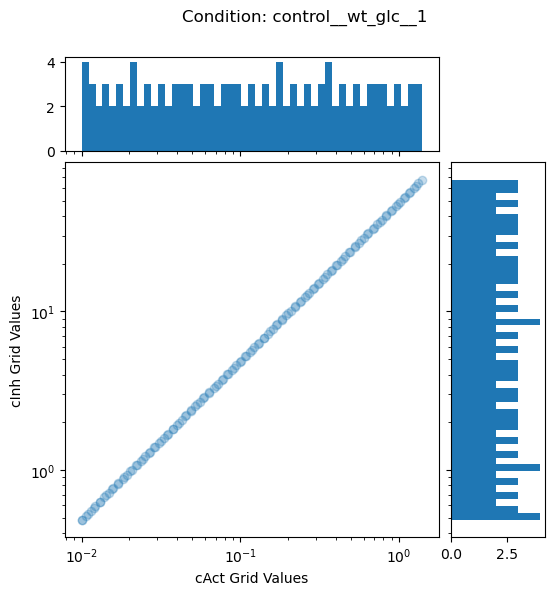

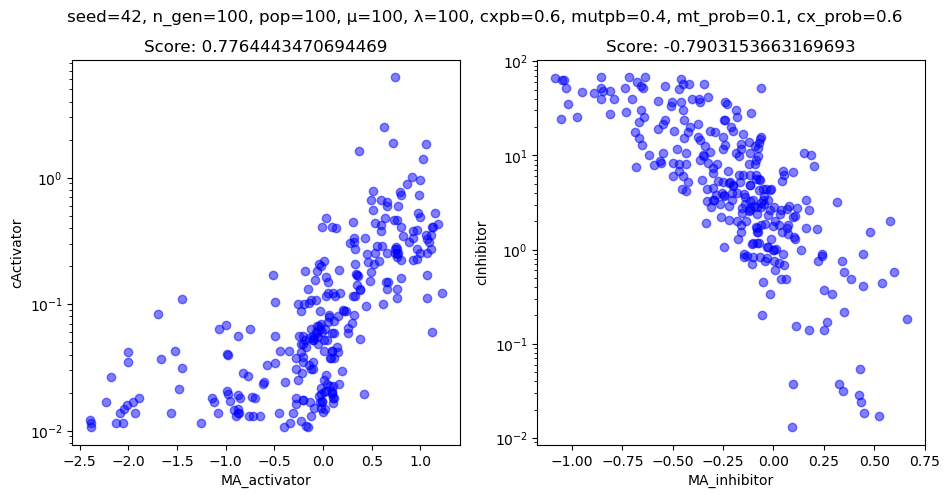

In [7]:
# determine cActivator and cInhibior values, and greedy
greedy_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'_greedy.pkl'
norm_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'.pkl'
if flags['force_rerun']:
    return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
    if flags['run_greedy']:
        pickle_out = open(greedy_path, 'wb')
        pickle.dump(greedy_cAct_cInh_df, pickle_out)
        pickle_out.close()
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
    else:
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
else:
    if flags['run_greedy'] and os.path.exists(norm_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    elif os.path.exists(norm_path) and os.path.exists(greedy_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
        pickle_in = open(greedy_path, 'rb')
        greedy_cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    else: # need to rerun
        return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
        if flags['run_greedy']:
            pickle_out = open(greedy_path, 'wb')
            pickle.dump(greedy_cAct_cInh_df, pickle_out)
            pickle_out.close()
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
        else:
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
for fig in return_figs:
    gene_figs.append(fig)

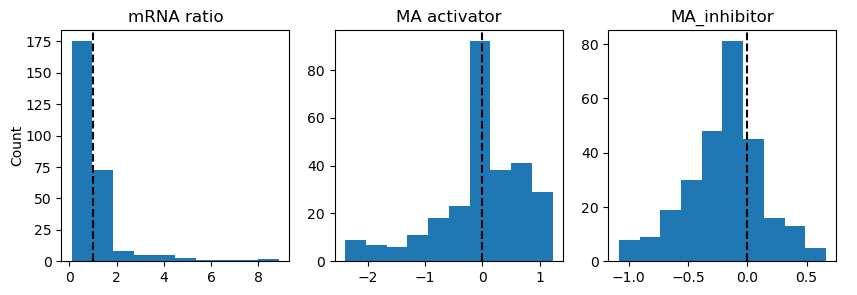

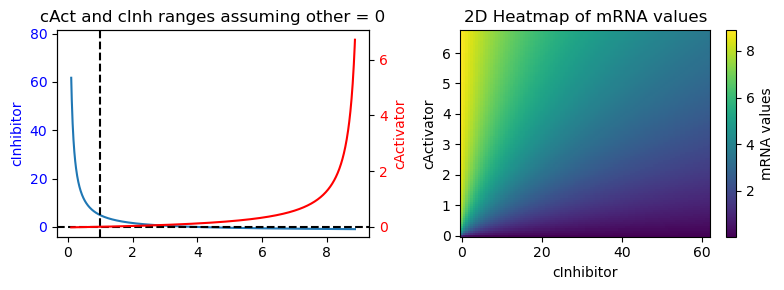

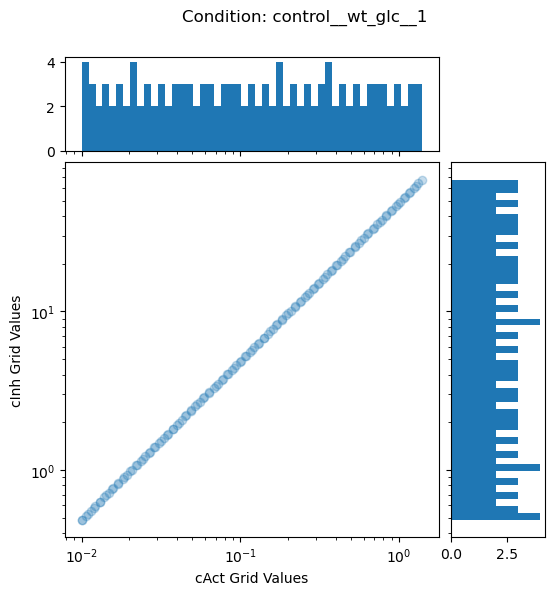

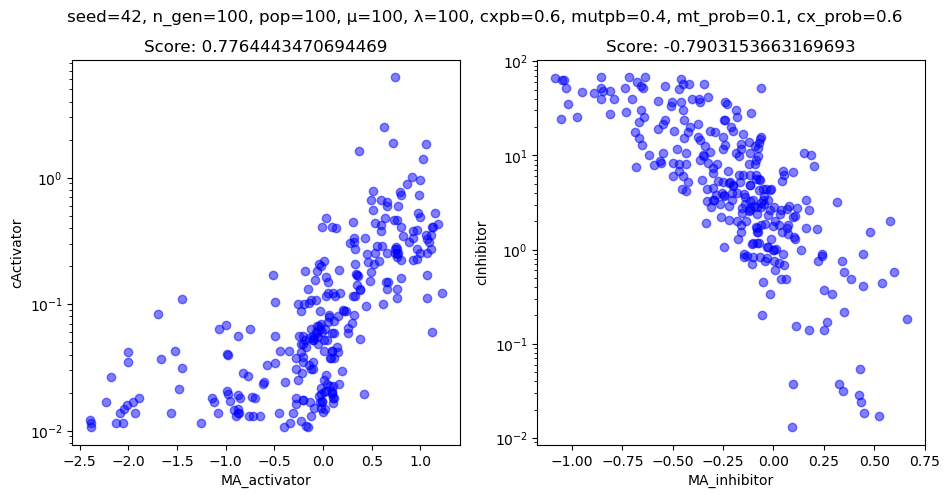

In [8]:
# show our gene_specific sanity plots
for fig in gene_figs:
    display(fig)

## don't do per gene

In [6]:
# run GAMs
if flags['force_rerun']:
    iG.run_GAMs(flags)

--- Job cAct_model Start 11/03/23 11:57:18 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/cAct_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- cAct_model.gms(10) 2 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cEff index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input.gdx
--- cAct_model.gms(11) 2 Mb
--

    461   4        2.7240493608E+02 9.9E-06   253 2.1E-04    2 F  T
    466   4        2.7240493608E+02 9.9E-06   252 8.3E-04    1 F  T
    471   4        2.7240493607E+02 9.7E-06   251 5.2E-01    1 F  T
    481   4        2.7240493605E+02 9.7E-06   250 9.4E+00    1 F  T
    491   4        2.7240493604E+02 9.7E-06   249 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    496   4        2.7240493603E+02 9.9E-06   249 9.9E-05    1 F  T
    501   4        2.7240493603E+02 9.7E-06   249 1.0E+00      F  T
    506   4        2.7240493603E+02 9.9E-06   249 7.3E-05    1 F  T
    511   4        2.7240493603E+02 9.9E-06   249 1.8E-05    1 F  T
    516   4        2.7240493602E+02 9.7E-06   249 1.0E+00    1 F  T
    521   4        2.7240493600E+02 9.7E-06   249 1.0E+00    1 F  T
    531   4        2.7240493592E+02 9.9E-06   249 5.3E-06      F  T
    536   4        2.7240493587E+02 9.9E-06   249 4.4E-04    1 F  T
    541   4        2.7240493587E+02 9.7E-06  

     81   4        2.9753577726E+02 6.8E-01   107 4.3E+00      F  T
     86   4        2.9701070257E+02 1.5E+00   106 1.0E+01    1 F  T
     91   4        2.9688536133E+02 6.3E-01   104 2.4E-02    1 F  T
    101   4        2.9562864096E+02 2.2E+00   124 5.1E-01      F  T
    106   4        2.9508489116E+02 8.0E-01   123 4.2E-02    1 F  T
    111   4        2.9489105321E+02 8.7E-01   123 1.0E+00    1 F  T
    116   4        2.9484054932E+02 1.9E-01   122 8.8E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    121   4        2.9482663275E+02 6.2E-01   121 1.0E+00    1 F  T
    126   4        2.9481534737E+02 1.9E-01   120 1.0E+00    1 F  T
    131   4        2.9377337356E+02 1.4E+00   139 1.0E+00      F  T
    141   4        2.9273125766E+02 1.1E+00   136 1.0E+01    1 F  T
    146   4        2.9265858379E+02 3.5E-01   135 1.8E+00    1 F  T
    151   4        2.9262161405E+02 7.4E-01   133 1.0E-02    1 F  T
    156   4        2.9261135576E+02 5.3E-01  

    751   4        2.8617128768E+02 1.2E+00   121 4.8E-06    1 F  T
    756   4        2.8617118139E+02 7.0E-01   121 1.9E+01    1 F  T
    761   4        2.8617055504E+02 8.2E-01   121 3.4E-05    1 F  T
    766   4        2.8617010236E+02 1.8E+00   121 1.3E-01    1 F  T
    771   4        2.8616955617E+02 1.5E+00   120 1.4E-02      F  T
    781   4        2.8616815359E+02 5.3E-01   119 6.9E-05    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    786   4        2.8616760896E+02 2.9E+00   118 1.0E+00    1 F  T
    791   4        2.8615153617E+02 2.1E+00   125 4.1E+00    1 F  T
    796   4        2.8613266810E+02 8.9E-01   123 7.6E+00    1 F  T
    801   4        2.8604123566E+02 1.7E+00   122 1.8E-01      F  T
    811   4        2.8601272269E+02 7.9E-01   120 4.2E+00    1 F  T
    816   4        2.8600986677E+02 1.6E+00   119 1.0E+00    1 F  T
    821   4        2.8600794352E+02 7.6E-01   119 6.9E-01    1 F  T
    826   4        2.8600590993E+02 7.0E-01  

   1461   4        2.8493571698E+02 1.4E+00    78 6.4E-06    1 F  T
   1466   4        2.8493569491E+02 9.3E-01    77 3.3E+00    1 F  T
   1471   4        2.8493564765E+02 2.1E+00    77 4.5E-06    1 F  T
   1476   4        2.8493557340E+02 5.8E-01    77 1.0E+00    1 F  T
   1481   4        2.8493552500E+02 3.0E+00    77 6.2E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   1486   4        2.8493544058E+02 7.3E-01    77 5.2E-06    1 F  T
   1491   4        2.8493541817E+02 3.6E+00    75 2.0E+01    1 F  T
   1496   4        2.8493538730E+02 1.5E+00    74 3.9E-06    1 F  T
   1501   4        2.8493530240E+02 4.7E+00    78 5.4E-04      F  T
   1511   4        2.8493527506E+02 4.2E+00    78 1.9E+02    1 F  T
   1516   4        2.8493524871E+02 9.8E-01    78 1.6E-05    1 F  T
   1521   4        2.8493523150E+02 6.1E-01    75 1.0E+00    1 F  T
   1531   4        2.8493519858E+02 8.5E-01    73 2.5E-01    1 F  T
   1536   4        2.8493518197E+02 1.1E+00  

   2186   4        2.8438260610E+02 9.2E-01    35 1.3E-07    1 F  T
   2191   4        2.8438260566E+02 1.8E+00    35 6.2E-06      F  T
   2201   4        2.8438260408E+02 9.2E-01    34 4.6E-01    1 F  T
   2206   4        2.8438260362E+02 1.5E+00    33 1.4E-08    1 F  T
   2211   4        2.8438260308E+02 2.4E+00    35 2.8E-08      F  T
   2221   4        2.8438260301E+02 2.4E+00    33 1.0E+00    1 F  T
   2231   4        2.8438260298E+02 1.4E+00    33 2.2E-10      F  T
   2236   4        2.8438260298E+02 2.9E+00    33 5.3E-10    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2241   4        2.8438260295E+02 8.9E-01    34 1.0E-07      F  T
   2246   4        2.8438260295E+02 1.3E+00    33 4.6E-10    2 F  T
   2251   4        2.8438260293E+02 2.5E+00    33 1.0E+00    1 F  T
   2261   4        2.8438260275E+02 8.1E-01    32 9.4E-06      F  T
   2266   4        2.8438260255E+02 8.1E-01    31 9.4E-10    1 F  T
   2271   4        2.8438260246E+02 8.1E-01  

   2861   4        2.8380788409E+02 9.0E-01    31 1.0E+00    1 F  T
   2866   4        2.8380765051E+02 1.0E+00    31 3.4E-01    1 F  T
   2871   4        2.8380740994E+02 5.4E+00    31 5.5E-05    1 F  T
   2881   4        2.8380575326E+02 9.0E-01    30 4.1E-03      F  T
   2886   4        2.8380357400E+02 1.6E+00    29 1.0E-04    1 F  T
   2891   4        2.8379673050E+02 1.8E+00    29 1.2E-04    1 F  T
   2901   4        2.8379502505E+02 6.9E-01    29 2.7E-06      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2906   4        2.8379495559E+02 2.3E+00    28 4.4E+00    1 F  T
   2911   4        2.8379483650E+02 9.0E-01    26 2.4E+00    1 F  T
   2921   4        2.8378456914E+02 2.4E+00    31 2.5E-03    1 F  T
   2926   4        2.8378375628E+02 8.0E-01    29 3.3E+00    1 F  T
   2931   4        2.8378289984E+02 3.0E+00    28 6.3E-02      F  T
   2941   4        2.8378241716E+02 1.4E+00    27 1.0E-04    1 F  T
   2951   4        2.8378225832E+02 6.9E-01  

 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3611   4        2.8325348363E+02 1.4E+00    38 1.4E+01    1 F  T
   3616   4        2.8319425254E+02 3.3E+00    37 1.1E-02    1 F  T
   3621   4        2.8310027638E+02 1.4E+00    36 1.0E+00    1 F  T
   3626   4        2.8303147467E+02 2.6E+00    37 5.3E-03    1 F  T
   3631   4        2.8301317861E+02 8.2E-01    35 1.0E+00    1 F  T
   3636   4        2.8300222337E+02 1.9E+00    36 4.1E-03    1 F  T
   3641   4        2.8297874207E+02 6.9E-01    33 3.0E-02    1 F  T
   3651   4        2.8293287112E+02 8.2E-01    31 5.0E-01      F  T
   3656   4        2.8291771216E+02 1.8E+00    34 7.2E+00    1 F  T
   3661   4        2.8289358429E+02 1.2E+00    33 1.3E-03    3 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3671   4        2.8288637857E+02 1.7E+00    30 2.0E+00    1 F  T
   3676   4        2.8288436620E+02 1.3E+00    29 2.0E-04    1 F  T
   3681   4        2.8288382328E+02 1.3E+0

   4321   4        2.8274470564E+02 9.2E-01     8 3.4E-03      F  T
   4331   4        2.8274470440E+02 9.2E-01     8 1.6E-06    1 F  T
   4336   4        2.8274470377E+02 1.9E+00     7 3.3E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   4341   4        2.8274470371E+02 9.2E-01     7 2.9E-11      F  T
   4346   4        2.8274470368E+02 9.6E-01     6 1.5E-08    1 F  T
   4351   4        2.8274470266E+02 8.1E-01     6 1.0E+00    1 F  T
   4361   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4366   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4371   4        2.8274469904E+02 1.2E+00    23 3.0E-05      F  T
   4381   4        2.8274292572E+02 1.0E+00    21 1.2E-04      F  T
   4391   4        2.8274254406E+02 1.4E+00    17 4.4E-04    1 F  T
   4401   4        2.8274186375E+02 1.6E+00    15 1.0E+00    1 F  T
   4411   4        2.8274169218E+02 4.8E+00    15 5.8E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax 

   5066   4        2.8267906042E+02 9.2E-01    11 6.1E+00    1 F  T
   5071   4        2.8267904707E+02 9.9E-01    10 1.3E-01      F  T
   5076   4        2.8267904408E+02 8.2E-01    10 5.3E-01    1 F  T
   5081   4        2.8267904383E+02 2.6E+00    10 5.8E-08    1 F  T
   5086   4        2.8267904382E+02 1.4E+00     9 4.0E+00    1 F  T
   5091   4        2.8267904377E+02 7.7E-01     8 1.0E+00    1 F  T
   5096   4        2.8267904376E+02 1.1E+00    10 7.2E-09    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   5101   4        2.8267904373E+02 1.8E+00     9 6.4E-09    1 F  T
   5111   4        2.8267902268E+02 1.5E+00     8 1.0E+00    1 F  T
   5116   4        2.8267902207E+02 5.9E-01     8 1.5E-01    1 F  T
   5121   4        2.8267902206E+02 2.2E+00     8 9.5E-09    1 F  T
   5131   4        2.8267902203E+02 8.9E-01     7 1.9E-09    1 F  T
   5136   4        2.8267902203E+02 8.9E-01     5 3.6E-01    1 F  T
   5141   4        2.8267902203E+02 1.4E+00  

AttributeError: module 'interface_GAMS' has no attribute 'read_GAMs'

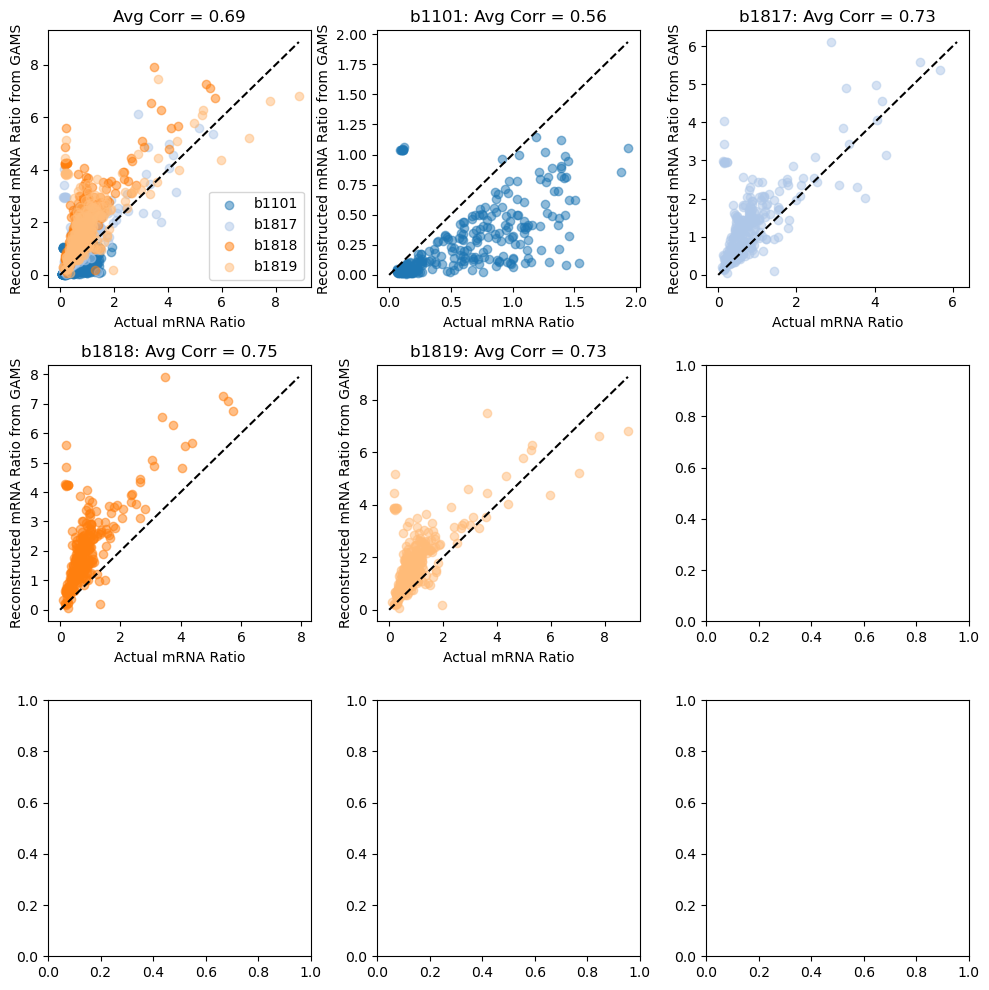

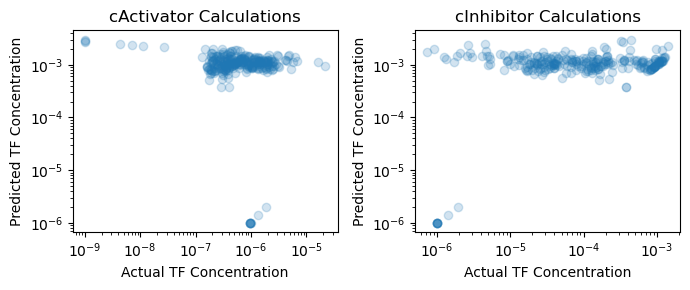

In [18]:
# read GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(flags)
if flags['sanity_plots']:
    
    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    for gene in calc_cAct.columns:
        # load grid constants
        gene_grid_name = '../data/gene_grid_constants/'+gene+'.pkl'
        pickle_in = open(gene_grid_name, 'rb')
        grid = pickle.load(pickle_in)
        pickle_in.close()

        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))

        actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.tight_layout()
    together_figs.append(fig)
    
    
    
    # TF conc values
    # histogram of TF_conc values
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    together_figs.append(fig)